# HAR LSTM training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X_train, labels_train, list_ch_train = read_data(data_path="./data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="./data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Standardize
X_train, X_test = standardize(X_train, X_test) 

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train,
                                                random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

### Hyperparameters

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/home/arasdar/anaconda3/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


In [7]:
lstm_size = 27         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 1000

# Fixed
n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [9]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [10]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [ ]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [ ]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%25 == 0):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.696601 Train acc: 0.318333
Epoch: 1/1000 Iteration: 10 Train loss: 1.705608 Train acc: 0.278333
Epoch: 1/1000 Iteration: 15 Train loss: 1.688112 Train acc: 0.330000
Epoch: 2/1000 Iteration: 20 Train loss: 1.682528 Train acc: 0.323333
Epoch: 2/1000 Iteration: 25 Train loss: 1.681423 Train acc: 0.330000
Epoch: 2/1000 Iteration: 25 Validation loss: 1.655036 Validation acc: 0.412778
Epoch: 3/1000 Iteration: 30 Train loss: 1.683265 Train acc: 0.313333
Epoch: 3/1000 Iteration: 35 Train loss: 1.656298 Train acc: 0.348333
Epoch: 4/1000 Iteration: 40 Train loss: 1.672438 Train acc: 0.321667
Epoch: 4/1000 Iteration: 45 Train loss: 1.667601 Train acc: 0.346667
Epoch: 5/1000 Iteration: 50 Train loss: 1.590535 Train acc: 0.423333
Epoch: 5/1000 Iteration: 50 Validation loss: 1.603563 Validation acc: 0.417778
Epoch: 6/1000 Iteration: 55 Train loss: 1.623085 Train acc: 0.361667
Epoch: 6/1000 Iteration: 60 Train loss: 1.603726 Train acc: 0.391667
Epoch: 7/1000 I

Epoch: 53/1000 Iteration: 480 Train loss: 0.909543 Train acc: 0.660000
Epoch: 53/1000 Iteration: 485 Train loss: 0.832468 Train acc: 0.688333
Epoch: 54/1000 Iteration: 490 Train loss: 0.874186 Train acc: 0.683333
Epoch: 54/1000 Iteration: 495 Train loss: 0.868158 Train acc: 0.705000
Epoch: 55/1000 Iteration: 500 Train loss: 0.778014 Train acc: 0.728333
Epoch: 55/1000 Iteration: 500 Validation loss: 0.743036 Validation acc: 0.785000
Epoch: 56/1000 Iteration: 505 Train loss: 0.820177 Train acc: 0.703333
Epoch: 56/1000 Iteration: 510 Train loss: 0.763879 Train acc: 0.743333
Epoch: 57/1000 Iteration: 515 Train loss: 0.820971 Train acc: 0.718333
Epoch: 57/1000 Iteration: 520 Train loss: 0.831136 Train acc: 0.690000
Epoch: 58/1000 Iteration: 525 Train loss: 0.822168 Train acc: 0.706667
Epoch: 58/1000 Iteration: 525 Validation loss: 0.710259 Validation acc: 0.801667
Epoch: 58/1000 Iteration: 530 Train loss: 0.809939 Train acc: 0.703333
Epoch: 59/1000 Iteration: 535 Train loss: 0.823894 Train 

Epoch: 105/1000 Iteration: 950 Validation loss: 0.441384 Validation acc: 0.827778
Epoch: 106/1000 Iteration: 955 Train loss: 0.537889 Train acc: 0.780000
Epoch: 106/1000 Iteration: 960 Train loss: 0.503183 Train acc: 0.808333
Epoch: 107/1000 Iteration: 965 Train loss: 0.538168 Train acc: 0.790000
Epoch: 107/1000 Iteration: 970 Train loss: 0.527135 Train acc: 0.788333
Epoch: 108/1000 Iteration: 975 Train loss: 0.520277 Train acc: 0.810000
Epoch: 108/1000 Iteration: 975 Validation loss: 0.436657 Validation acc: 0.826111
Epoch: 108/1000 Iteration: 980 Train loss: 0.511978 Train acc: 0.790000
Epoch: 109/1000 Iteration: 985 Train loss: 0.550194 Train acc: 0.790000
Epoch: 109/1000 Iteration: 990 Train loss: 0.523803 Train acc: 0.795000
Epoch: 110/1000 Iteration: 995 Train loss: 0.495868 Train acc: 0.796667
Epoch: 111/1000 Iteration: 1000 Train loss: 0.508368 Train acc: 0.810000
Epoch: 111/1000 Iteration: 1000 Validation loss: 0.431174 Validation acc: 0.825556
Epoch: 111/1000 Iteration: 1005 

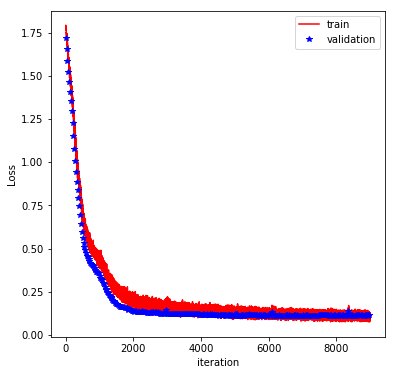

In [12]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 25 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

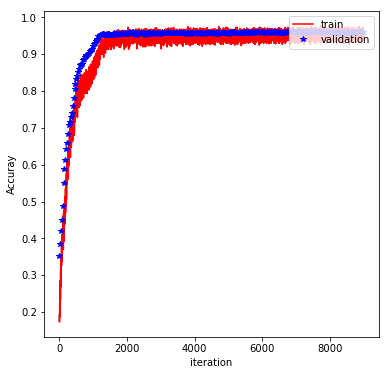

In [13]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 25 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [14]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

Test accuracy: 0.890833
